# Import libraries

In [36]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# Load data

In [50]:
x = pd.read_parquet('training_set_v6.parquet.gzip')
target = 'target'
y = x['target']
del x['target']

# Define a function for modeling and cross-validation

In [45]:
def modelfit(alg, dtrain, dtest, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['target'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['target'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['target'], dtrain_predprob)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

# Baseline Model

In [52]:
#Choose all predictors except target 
###predictors = [x for x in train.columns if x not in [target]]
##gbm0 = GradientBoostingClassifier(random_state=10)
#modelfit(gbm0, train, y, predictors)

Text(0,0.5,'Feature Importance Score')

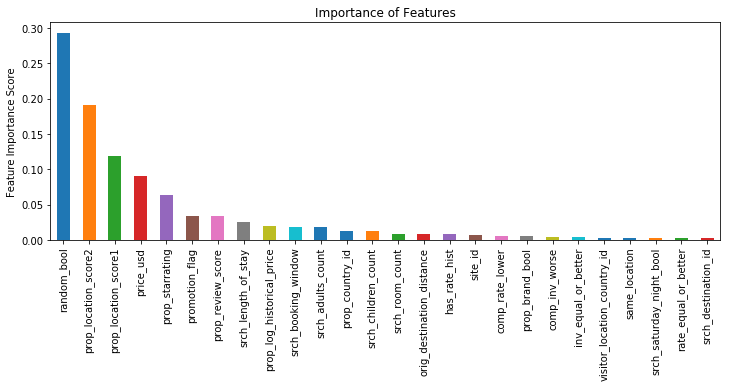

In [51]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV

baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(x,y)
predictors=list(x)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on training set: {:.3f}'.format(baseline.score(x, y)))
# pred=baseline.predict(X_test)
# print(classification_report(y_test, pred))

GBM Models:
There 2 types of parameters here:

Tree-specific parameters:
min_samples_split
min_samples_leaf
max_depth
min_leaf_nodes
max_features
loss function

Boosting specific paramters:
n_estimators
learning_rate
subsample

# Read in test data

In [54]:
x_test = pd.read_parquet('test_set_v6.parquet.gzip')



In [61]:
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(x_test, y)))
pred=baseline.predict(x_test)
# print(classification_report(y_test, pred))

Accuracy of the GBM on test set: 0.955


# Tuning parameters

Tunign n_estimators and Learning rate

In [ ]:
p_test3 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(x,y)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

max_depth

In [ ]:
p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01,n_estimators=1500, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(x,y)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

# First evaluation of new model on test set

In [ ]:

model1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
model1.fit(x,y)
predictors=list(x)
feat_imp = pd.Series(model1.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(model1.score(X_test, y_test)))
pred=model1.predict(X_test)
print(classification_report(y_test, pred))

# Other factors
Tree related parameters: Min sample split and min samples leaf

In [ ]:
p_test4 = {'min_samples_split':[2,4,6,8,10,20,40,60,100], 'min_samples_leaf':[1,3,5,7,9]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test4, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(x,y)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

Max features

In [ ]:
#TUNING MAX FEATURES
p_test5 = {'max_features':[2,3,4,5,6,7]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7, subsample=1, random_state=10), 
param_grid = p_test5, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(x,y)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

Subsample

In [ ]:

p_test6= {'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , random_state=10), 
param_grid = p_test6, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(x,y)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

# Evaluation of final model on Test set

In [ ]:
new=GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , subsample=0.95, random_state=10)
new.fit(x,y)
predictors=list(x)
feat_imp = pd.Series(new.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(new.score(X_test, y_test)))
pred=new.predict(X_test)
print(classification_report(y_test, pred))

# Comparison of ROC AUC

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 


#run models
baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train,y_train)

model1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
model1.fit(X_train,y_train)

new=GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , subsample=0.95, random_state=10)
new.fit(X_train,y_train)

#calculate values for ROC AUC plot
#baseline model
baseline_roc_auc = roc_auc_score(y_test, baseline.predict(X_test))
fprB, tprB, thresholdsB = roc_curve(y_test, baseline.predict_proba(X_test)[:,1])
#model 1
model1_roc_auc = roc_auc_score(y_test, model1.predict(X_test))
fpr1, tpr1, thresholds1 = roc_curve(y_test, model1.predict_proba(X_test)[:,1])
#new tuned model 
new_roc_auc = roc_auc_score(y_test, new.predict(X_test))
fprnew, tprnew, thresholds_new = roc_curve(y_test, new.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fprB, tprB, label='GBM Baseline (area = %0.2f)' % baseline_roc_auc)
plt.plot(fpr1, tpr1, label='GBM Model 1 (area = %0.2f)' % model1_roc_auc)
plt.plot(fprnew, tprnew, label='GBM Final Model (area = %0.2f)' % new_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()